##### Summary of exercise

The section explores Bayesian modelling within the framework of linear regression. 

Traditional approaches focused on maximizing likelihood or minimizing the least square differences are both susceptible to overfitting.

Maximizing likelihood inherently drives the addition of more parameters to the model to boost accuracy. This leads to increased model complexity, which may compromise the models ability to generalize to new data. This is the problem of overfitting.

Regularization techniques can help to offset the problem of overfitting by penalizing superfluous parameters, but their efficacy depends on the specific regularization employed, since certain basis functions can skew the results towards bias or variance.

In contrast, the Bayesian approach makes use of a prior distribution of expected model parameters. The expected probabilities then update through subsequent observations of data, called the posterior distribution. This method can help address issues with overfitting, since the model will always estimate model parameters with respect to the initial prior distribution to some extent.

In this exercise, the goal is to recreate figure 3.7 page 155 from https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf using python, C#, and Bonsai.

Here is the figure generation in python.

##### Import libraries and set random seed

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from pathlib import Path

# Set random seed
np.random.seed(10)

##### Create plotting classes

In [2]:
class BasePlot(object):
    """
    Class to create a base plot.

    Parameters
    ----------
    axis : matplotlib.pyplot.Axes
        subplot of the figure

    Attributes
    ----------
    axis : matplotlib.pyplot.Axes
        the specific subplot of a matplotlib figure
    """

    def __init__(self, axis: plt.Axes):
        """
        Initialize BasePlot instance.
        """
        self.axis = axis

    def format_axes(self):
        """
        Function to set the tick locations and tick labels on both axes of the subplot.
        """

        # Set x axis ticks, labels, position, and limits
        self.axis.set_xticks([-1, 0, 1])
        self.axis.set_xticklabels([-1, 0, 1])
        self.axis.xaxis.set_label_coords(0.75, -0.05)
        self.axis.set_xlim(-1, 1)

        # Set y axis ticks, labels, position, and limits
        self.axis.set_yticks([-1, 0, 1])
        self.axis.set_yticklabels([-1, 0, 1])        
        self.axis.yaxis.set_label_coords(-0.08, 0.7)
        self.axis.set_ylim(-1, 1)

    def set_title(self, title: str):
        """
        Function to set the title of the subplot.

        Parameters
        ----------
        title : str
            title of the subplot       
        """

        # Set title
        self.axis.set_title(title)


class HiddenPlot(BasePlot):
    """
    Class to create a hidden plot with no axes showing.

    Derived from the `BasePlot` class.

    Parameters
    ----------
    axis : matplotlib.pyplot.Axes
        subplot of the figure

    title: str, optional
        title of the specific subplot

    Attributes
    ----------
    axis : matplotlib.pyplot.Axes
        the specific subplot of a matplotlib figure
    """

    def __init__(self, axis: plt.Axes, title: str = None):
        """
        Initialize HiddenPlot instance.
        """
        super().__init__(axis)

        # Hide axes spines
        self.axis.spines['top'].set_visible(False)
        self.axis.spines['right'].set_visible(False)
        self.axis.spines['bottom'].set_visible(False)
        self.axis.spines['left'].set_visible(False)

        # Hide tick labels
        self.axis.get_xaxis().set_ticks([])
        self.axis.get_yaxis().set_ticks([])

        # Set title if provided
        if title is not None:
            self.set_title(title)


class PriorPosteriorPlot(BasePlot):
    """
    Class to create a prior/posterior plot.

    Derived from the `BasePlot` class.

    Parameters
    ----------
    axis : matplotlib.pyplot.Axes
        subplot of the figure

    data_imshow: numpy.ndarray
        data of the prior/posterior distribution over parameter space provided to the imshow function (w0, w1)

    data_scatter_x: numpy.ndarray, optional
        data to show along the x axis of the scatter plot (w0)

    data_scatter_y: numpy.ndarray, optional
        data to show along the y axis of the scatter plot (w1)
        
    title: str, optional
        title of the specific subplot

    Attributes
    ----------
    axis : matplotlib.pyplot.Axes
        the specific subplot of a matplotlib figure
    """

    def __init__(self, 
                axis: plt.Axes,
                data_imshow: np.ndarray, 
                data_scatter_x: np.ndarray = None, 
                data_scatter_y: np.ndarray = None, 
                title: str = None):
        
        """
        Initialize PriorPosteriorPlot instance.
        """

        super().__init__(axis)

        # Set axes labels
        self.axis.set_xlabel(r'$w_0$')
        self.axis.set_ylabel(r'$w_1$', rotation=0)

        # Plot imshow data
        self.imshow(data_imshow)

        # Plot scatter data if present
        if data_scatter_x is not None and data_scatter_y is not None:
            self.scatter(data_scatter_x, data_scatter_y)

        # Set title if present
        if title is not None:
            self.set_title(title)

        # Format axes
        self.format_axes()
    
    def imshow(self, image: np.ndarray):
        """
        Function to show the image data on the subplot.
        """
        self.axis.imshow(image, cmap='jet', aspect = 'equal', extent=[-1, 1, -1, 1], origin = 'lower')

    def scatter(self, x, y):
        """
        Function to show the scatter data on the subplot.
        """
        self.axis.scatter(x, y, s = 100, c = 'white', marker="+", zorder = 2)


class DataSpacePlot(BasePlot):

    """
    Class to create a data space plot.

    Derived from the `BasePlot` class.

    Parameters
    ----------
    axis : matplotlib.pyplot.Axes
        subplot of the figure

    data_plot_x: numpy.ndarray
        data points along the x axis of the plot (x)

    data_plot_y: numpy.ndarray
        array containing all of the y data points for each linear equation (ys)

    data_scatter_x: numpy.ndarray, optional
        data to show along the x axis of the scatter plot (x)
        
    data_scatter_y: numpy.ndarray, optional
        data to show along the y axis of the scatter plot (y)
        
    title: str, optional
        title of the specific subplot

    Attributes
    ----------
    axis : matplotlib.pyplot.Axes
        the specific subplot of a matplotlib figure
    """

    def __init__(self,
                 axis: plt.Axes, 
                 data_plot_x: np.ndarray, 
                 data_plot_y: np.ndarray,
                 data_scatter_x: np.ndarray = None, 
                 data_scatter_y: np.ndarray = None,
                 title: str = None):
        """
        Initialize DataSpacePlot instance.
        """
        
        super().__init__(axis)

        # Set axes labels
        self.axis.set_xlabel(r'$x$')
        self.axis.set_ylabel(r'$y$', rotation=0)

        # Plot each y data array in data_plot_y against x
        [self.plot(data_plot_x, y) for y in data_plot_y]

        # Plot scatter data if present
        if data_scatter_x is not None and data_scatter_y is not None:
            self.scatter(data_scatter_x, data_scatter_y)

        # Set title of plot if present
        if title is not None:
            self.set_title(title)

        # Format axes
        self.format_axes()

    def plot(self, x, y):
        """
        Function to plot x and y data.
        """
        self.axis.plot(x, y, c = 'red', lw = 2)
        
    def scatter(self, x, y):
        """
        Function to plot scatter data.
        """
        self.axis.scatter(x, y, facecolors="none", edgecolors = "blue", marker = "o", lw = 2, zorder = 2)


class LikelihoodPlot(PriorPosteriorPlot):
    """
    Class to create a likelihood plot.

    Derived from the `PriorPosteriorPlot` class.

    Parameters
    ----------
    *args
        Additional arguments passed on to `PriorPosteriorPlot` base class. Should be passed as keyword arguments.
    **kwargs
        Additional keyword arguments passed on to `PriorPosteriorPlot` base class.
    """
    def __init__(self, *args, **kwargs):
        """
        Initialize LikelihoodPlot instance.
        """
        super().__init__(*args, **kwargs)

##### Create synthetic data class

In [3]:
class SyntheticData():
    """
    Class to create a synethic dataset using a linear function of the expression,

        t = f(x,a,b) = a0 + a1 * x + B

    where a0 and a1 are known parameters and B is added gaussian noise given by the sigma parameter.     

    Parameters
    ----------
    a0 : float
        first parameter of the linear equation

    a1: float
        second parameter of the linear equation

    sigma: float
        standard deviation that defines the gaussian noise distribution

    Attributes
    ----------
    a0 : float
        first parameter of the linear equation

    a1: float
        second parameter of the linear equation

    sigma: float
        standard deviation that defines the gaussian noise distribution

    x: numpy.ndarray
        values of x in the dataset that were randomly sampled from a uniform distribution between (-1, 1)
    
    t: numpy.ndarray
        results of the linear function evaluated at x (target values)
    """

    def __init__(self, 
                 a0: float, 
                 a1: float, 
                 sigma: float):
        """
        Initialize SyntheticData instance.
        """

        # parameter 1
        self.a0 = a0

        # parameter 2
        self.a1 = a1

        # noise standard deviation
        self.sigma = sigma

        # gaussian noise distribution
        self.noise = norm(0, self.sigma)

        # initialized x samples
        self.x = np.array([])

        # initialized target samples
        self.t = np.array([])


    def add_data_samples(self, n_samples: int):
        """
        Function to add samples to the synthetic dataset. Note, this does not overwrite existing samples, only appends new samples.

        Parameters
        ----------
        n_samples: int
            number of additional samples to add to the dataset
        """

        # randomly sample x data from a uniform distribution
        new_x = np.random.uniform(-1, 1, n_samples)

        # add x samples
        self.x = np.append(self.x, new_x)

        # Evaluate the linear function f(x,a)
        new_fx = self.a0 + self.a1 * new_x

        # Add noise to output to create f(x,a,B) = t
        new_t = new_fx + self.noise.rvs(size = n_samples)

        # add t samples
        self.t = np.append(self.t, new_t)

    def add_data_samples_from_file(self, path_to_file: str, n_samples: int, start_sample: int = 0, skip_header: bool = True):
        """
        Function to add samples to the synthetic dataset from a csv file. Note, this does not overwrite existing samples, only appends new samples.

        Parameters
        ----------
        path_to_file: str
            path to the filename in storage. Must be in .csv format
        n_samples: int
            number of additional samples to add to the dataset
        start_sample: int, default = 0
            row of csv file to start reading data. If skip_header is True, 0 will become the row after the header.
        skip_header: bool, default = True
            option to skip the header (first row) of the csv file
        """

        # check that the path to the file is valid and has correct extension
        if not Path(path_to_file).exists():
            raise ValueError("File does not exist or path could not be found!")
        
        if not Path(path_to_file).suffix == ".csv":
            raise ValueError("File is not a csv file!")

        (new_x, new_t) = np.loadtxt(path_to_file, dtype=float, delimiter=",", skiprows=(1*skip_header)).reshape(-1, 2).T[:, start_sample:start_sample+n_samples]
        
        self.x = np.append(self.x, new_x)
        self.t = np.append(self.t, new_t)
            


##### Create class for bayesian model

In [4]:
class BayesianModel():
    """
    Class to create a bayesian model for performing regression on a linear function. 
    
    Assumes a gaussian prior and requires the hyperparameters alpha and beta.

    Assumes gaussian 

    Parameters
    ----------
    beta : float
        hyperparameter which describes the precision of the likelihood

    alpha: float
        hyperparameter which describes the precision of the prior

    Attributes
    ----------
    beta : float
        hyperparameter which describes the precision of the likelihood

    alpha: float
        hyperparameter which describes the precision of the prior

    pos: numpy.ndarray
        2 dimensional grid describing the parameter space (w0, w1) with 100 linearly space values between (-1, 1)

    mean_prior: numpy.ndarray
        array describing the mean of the prior for both parameters (w0, w1)

    covariance_prior: numpy.ndarray
        array describing the covariance weight matrix of the prior, derived from the precision hyperparameter (alpha)
    
    prior_dist: scipy.stats.multivariate_normal
       distribution of the prior over parameter space (w0, w1)

    prior_pdf: numpy.ndarray
        probability density function of the prior evaluated in parameter space (w0, w1)

    mean_post: numpy.ndarray
        array describing the mean of the posterior for both parameters (w0, w1)

    covariance_post: numpy.ndarray
        array describing the covariance weight matrix of the posterior, derived from the precision hyperparameter (alpha)
    
    post_dist: scipy.stats.multivariate_normal
       distribution of the posterior over parameter space (w0, w1)

    post_pdf: numpy.ndarray
        probability density function of the posterior evaluated in parameter space (w0, w1)

    likelihood_grid: numpy.ndarray
        likelihood of finding point t, the most recently added datapoint, given the predicted value of the model and the expected noise, derived from the precision hyperparameter (beta)
    """

    def __init__(self, 
                 beta: float, 
                 alpha: float):
        """
        Initialize BayesianModel instance.
        """

        # hyperparameter associated with precision of the likelihood
        self.beta = beta

        # hyperparameter associated with precision of the prior
        self.alpha = alpha 

        # intialize parameter space
        self.initialize_parameter_space()

        # calculate the prior
        self.calculate_prior_distribution()

    def initialize_parameter_space(self):
        """
        Initialize the parameter space.
        """
        # Specify grid size
        grid_size = 100

        # Create parameter values
        A0, A1 = np.meshgrid(np.linspace(-1, 1, grid_size), np.linspace(-1, 1, grid_size))

        # Create parameter space
        self.pos = np.dstack((A0, A1))

    def calculate_prior_distribution(self):
        """
        Function to calculate the prior distribution over parameter space.
        """
        # Define prior distribution parameters
        self.mean_prior = np.array([0, 0])
        self.covariance_prior = np.linalg.inv(self.alpha * np.eye(2))
        
        # Initialize prior distribution
        self.prior_dist = multivariate_normal(self.mean_prior, self.covariance_prior)

        # Generate pdf of prior
        self.prior_pdf = self.prior_dist.pdf(self.pos)

    def calculate_posterior_distribution(self, observations: SyntheticData):
        """
        Function to calculate the posterior distribution over parameter space, given a set of observations.

        Parameters
        ----------
        observations: SyntheticData
            object which contains synthetic data with values at x and t

        """
        # Construct the design matrix
        A = np.vstack((np.ones_like(observations.x), observations.x)).T

        # Calculate the posterior parameters
        self.covariance_post = np.linalg.inv(self.covariance_prior + self.beta * A.T @ A)
        self.mean_post = self.covariance_post @ (self.covariance_prior @ self.mean_prior + self.beta * A.T @ observations.t)

        # Calculate the posterior distribution
        self.post_dist = multivariate_normal(self.mean_post, self.covariance_post)

        # Generate pdf of posterior
        self.post_pdf = self.post_dist.pdf(self.pos)
    
    def calculate_likelihood(self, 
                             observations: SyntheticData, 
                             w: float, 
                             i: int = -1):
        """
        Function to calculate the likelihood of observing point (x_i, t_i) for a specific set of parameters (w).

        Parameters
        ----------
        observations: SyntheticData
            object which contains synthetic data with values at x and t

        w: numpy.ndarray
            array containing a specific combination of parameters (w0, w1)

        i: int
            index to use for sampling observations (x, t)

        Returns
        -------
        likelihood: numpy.ndarray
            array containing a single value of the likelihood

        """

        # Construct the design matrix
        A = np.vstack((np.ones_like(observations.x[i]), observations.x[i])).T

        # Calculate the predicted values of w given the last data sample
        prediction = np.dot(A, w)

        # Calculate the error between the predicted and actual data
        error = observations.t[i] - prediction

        # Calculate the likelihood of the specific point, P(t_i|f(x_i,w),b)
        likelihood = norm.pdf(error, scale = 1/np.sqrt(self.beta))

        return likelihood

    def calculate_likelihood_grid(self, observations: SyntheticData):
        """
        Function to calculate the likelihood over the entire parameter space (w0, w1).

        Parameters
        ----------
        observations: SyntheticData
            object which contains synthetic data with values at x and t
        """

        # Initialize likelihood grid
        self.likelihood_grid = np.zeros(self.pos.shape[:2])

        # Calculate likelihood over parameter space
        for i in range(self.pos.shape[0]):
            for j in range(self.pos.shape[1]):
                w = self.pos[i, j]
                likelihood = self.calculate_likelihood(observations, w)
                self.likelihood_grid[i, j] = likelihood

    def draw_random_samples_from_prior_and_evaluate(self, n_samples:int = 6):
        """
        Function to draw random samples from the prior distribution and evaluate the linear function.

        Parameters
        ----------
        n_samples: int, default = 6
            number of samples to randomly draw from the prior distribution
        """

        # Randomly sample from prior distribution
        data_samples = self.prior_dist.rvs(size = n_samples)

        # Generate x values to evaluate the randomly sampled parameters
        x = np.linspace(-1, 1, 1000)

        # Evaluate linear function
        ys = data_samples[:, 0][:,np.newaxis] + data_samples[:, 1][:,np.newaxis] * x

        return x, ys
    
    def draw_random_samples_from_posterior_and_evaluate(self, n_samples:int = 6):
        """
        Function to draw random samples from the posterior distribution and evaluate the linear function.

        Parameters
        ----------
        n_samples: int, default = 6
            number of samples to randomly draw from the prior distribution
        """

        # Randomly sample from posterior distribution
        data_samples = self.post_dist.rvs(size = n_samples)

        # Generate x values to evaluate the randomly sampled parameters
        x = np.linspace(-1, 1, 1000)

        # Evaluate linear function
        ys = data_samples[:, 0][:,np.newaxis] + data_samples[:, 1][:,np.newaxis] * x

        return x, ys


##### Run bayesian model and create figure

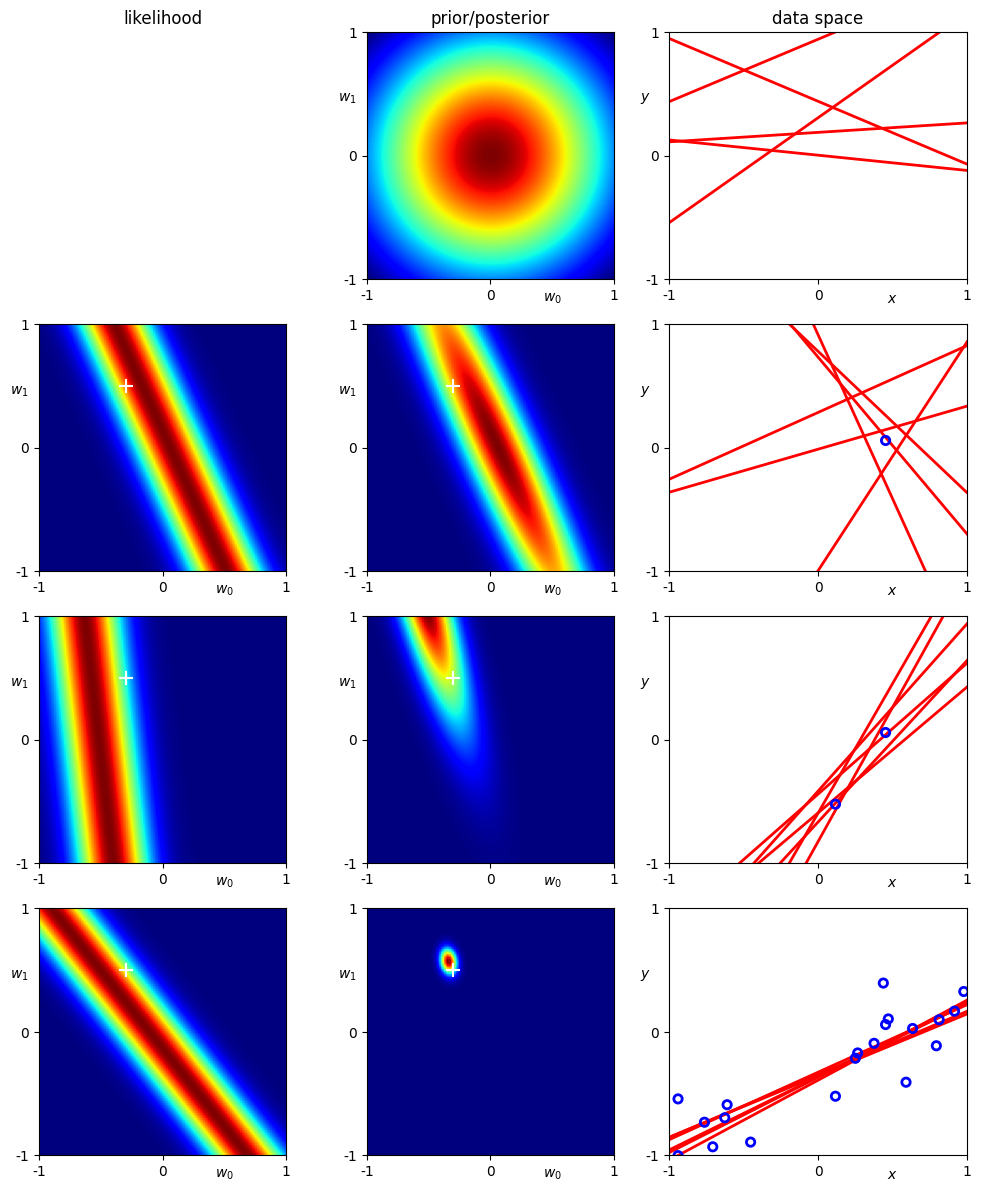

In [5]:
# Set parameters for the synthetic dataset
a0 = -0.3
a1 = 0.5
sigma = 0.2

# Set parameters for the bayesian model
beta = 25
alpha = 2


# Initialize figure canvas
fig, axs = plt.subplots(4, 3, figsize=(10, 12))

# Hide the first axis in the top left
HiddenPlot(axis = axs[0, 0],
           title = "likelihood")


# Initialize the Bayesian model
bayesian_model = BayesianModel(beta = beta, 
                               alpha = alpha)

# Show the prior distribution before any data
PriorPosteriorPlot(axis = axs[0,1], 
                   data_imshow = bayesian_model.prior_pdf, 
                   title = "prior/posterior")

# Sample the prior distribution for a random set of parameters and evaluate them on the linear function
x, ys = bayesian_model.draw_random_samples_from_prior_and_evaluate()

# Plot the evaluated results of the linear parameters
DataSpacePlot(axis = axs[0,2],
              data_plot_x = x,
              data_plot_y = ys,
              title = "data space")


# Generate synthetic data
synthetic_data = SyntheticData(a0 = a0, 
                               a1 = a1, 
                               sigma = sigma)

# Add a 1 data point to the synthetic dataset
synthetic_data.add_data_samples(1)

# read 1 synthetic data point in from csv file - use this to verify similar results across Python, C# and Bonsai
# synthetic_data.add_data_samples_from_file(path_to_file="../data/synthetic_data.csv", n_samples=1)

# Calculate the likelihood distribution
bayesian_model.calculate_likelihood_grid(synthetic_data)

# Plot the likelihood function after adding a single data point
LikelihoodPlot(axis = axs[1,0],
               data_imshow = bayesian_model.likelihood_grid,
               data_scatter_x = synthetic_data.a0, 
               data_scatter_y = synthetic_data.a1)

# Calculate the posterior distribution
bayesian_model.calculate_posterior_distribution(synthetic_data)

# Show the posterior distribution after a single data sample
PriorPosteriorPlot(axis = axs[1,1],
                   data_imshow = bayesian_model.post_pdf, 
                   data_scatter_x = synthetic_data.a0,
                   data_scatter_y = synthetic_data.a1)

# Sample the posterior distribution for a random set of parameters
x, ys = bayesian_model.draw_random_samples_from_posterior_and_evaluate()

# Plot the evaluated results of the linear parameters
DataSpacePlot(axis = axs[1,2],
              data_plot_x = x,
              data_plot_y = ys,
              data_scatter_x = synthetic_data.x,
              data_scatter_y = synthetic_data.t)


# Add another data point to the synthetic dataset, bringing the total sample count up to 2
synthetic_data.add_data_samples(1)

# read another synthetic data in from csv file for a total of 2 - use this to verify similar results across Python, C# and Bonsai
# synthetic_data.add_data_samples_from_file(path_to_file="../data/synthetic_data.csv", n_samples=1, start_sample=1)

# Calculate the likelihood distribution
bayesian_model.calculate_likelihood_grid(synthetic_data)

# Plot the likelihood function after 2 samples
LikelihoodPlot(axis = axs[2,0],
               data_imshow = bayesian_model.likelihood_grid,
               data_scatter_x = synthetic_data.a0,
               data_scatter_y = synthetic_data.a1)

# Calculate the posterior distribution after 2 samples
bayesian_model.calculate_posterior_distribution(synthetic_data)

# Show the posterior distribution after 2 samples
PriorPosteriorPlot(axis = axs[2,1],
                   data_imshow = bayesian_model.post_pdf,
                   data_scatter_x = synthetic_data.a0,
                   data_scatter_y = synthetic_data.a1)

# Sample the posterior distribution for a random set of parameters
x, ys = bayesian_model.draw_random_samples_from_posterior_and_evaluate()

# Plot the evaluated results
DataSpacePlot(axis = axs[2,2], 
              data_plot_x = x, 
              data_plot_y = ys, 
              data_scatter_x = synthetic_data.x, 
              data_scatter_y = synthetic_data.t)


# Add 18 more data points to the synthetic dataset, bringing the total up to 20
synthetic_data.add_data_samples(18)

# read all 18 synthetic data points in from csv file - use this to verify similar results across Python, C# and Bonsai
# synthetic_data.add_data_samples_from_file(path_to_file="../data/synthetic_data.csv", n_samples=18, start_sample=2)

# Calculate the likelihood distribution
bayesian_model.calculate_likelihood_grid(synthetic_data)

# Plot the likelihood function after adding a single data point to the dataset
LikelihoodPlot(axis = axs[3,0], 
               data_imshow = bayesian_model.likelihood_grid, 
               data_scatter_x = synthetic_data.a0, 
               data_scatter_y = synthetic_data.a1)

# Calculate the posterior distribution after 20 samples
bayesian_model.calculate_posterior_distribution(synthetic_data)

# Show the posterior distribution after 20 samples
PriorPosteriorPlot(axis = axs[3,1], 
                   data_imshow = bayesian_model.post_pdf, 
                   data_scatter_x = synthetic_data.a0, 
                   data_scatter_y = synthetic_data.a1)

# Sample the posterior distribution for a random set of parameters
x, ys = bayesian_model.draw_random_samples_from_posterior_and_evaluate()

# Plot the evaluated results
DataSpacePlot(axis = axs[3,2], 
              data_plot_x = x, 
              data_plot_y = ys, 
              data_scatter_x = synthetic_data.x, 
              data_scatter_y = synthetic_data.t)

plt.tight_layout()
plt.show()